## Sampling From a Given Sigmoidal Cox Process

Use thinning procedure to sample from a sigmoidal cox process with gaussian intensity function as seen in 

- 'Adams, Ryan Prescott, Iain Murray, and David JC MacKay. "Tractable nonparametric Bayesian inference in Poisson processes with Gaussian process intensities." Proceedings of the 26th Annual International Conference on Machine Learning. ACM, 2009.'

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow

In [105]:
def logistic(X):
    return 1. / (1. + np.exp(-X))

def get_scp_samples(region_lims, upper_bound, mean, cov):
    
    # build GP with mean and cov 
    # TODO: gpflow
    
    # region lims: np.array of shape (D x 2), D dimension of input space
    D = region_lims.shape[0]
    
    assert(np.alltrue(region_lims[:,0] <= region_lims[:,1])) # , 'First entries of regional limits need to be smaller or equal to the second entries')
    
    # 1. calc measure
    V = np.prod(np.absolute(region_lims[:,0] - region_lims[:,1]), axis=0)
    # 2. sample from poisson 
    J = np.random.poisson(V * upper_bound)
    # 3. sample locations uniformly
    low  = region_lims[:,0]
    high = region_lims[:,1]
    sample_candidates = np.random.uniform(low=low, high=high, size=(J, D))
    # 4. sample function values using the GP
    mean_vals = mean(sample_candidates)
    cov_vals  = cov(sample_candidates)
    
    # 5. iterate over points and accept/reject
    # sample from the GP function
    vals = np.random.multivariate_normal(mean_vals, cov_vals)
    R = np.random.uniform(size=J)
    
    accept = R < logistic(vals)
    
    return sample_candidates[accept], sample_candidates, R

### a) 1d example

In [126]:
def ex_mean_fun(X):
    return np.squeeze(np.sin(X))
def ex_cov_fun(X):
    N = X.shape[0]
    return np.zeros((N, N))

upper_bound = 3

accepted_samples, all_samples, R = get_scp_samples(np.array([[0,10]]), upper_bound = upper_bound, mean=ex_mean_fun, cov=ex_cov_fun)

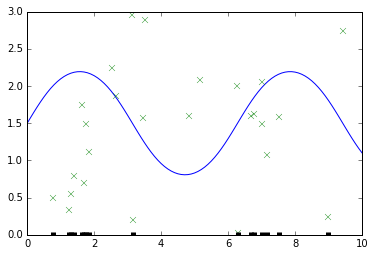

In [127]:
X = np.linspace(0,10, 101)
y = logistic(ex_mean_fun(X)) * upper_bound
plt.plot(X, y)

plt.plot(all_samples, R * upper_bound, 'x', mew=.4)

plt.plot(accepted_samples, np.zeros(accepted_samples.shape[0]), 'k|', mew=5)
plt.ylim(0, upper_bound)
plt.show()

### b) 2d example

In [ ]:
# TODO: add similar example for 2d input space